In [16]:
#import statements

import math
import matplotlib as  mpl
import matplotlib.pyplot as plt
import numpy as np
import PIL
import numpy.random as rande
import time

mpl.rcParams['savefig.dpi'] = 500
mpl.rcParams['figure.dpi'] = 500

#important physical constants

k = 1.380649 * (10 ** (-23)) #[J/K]
m = 9.10938356 * (10 ** (-31)) #[kg]
q = 1.60217662 * (10 ** (-19)) #[C]
c = 299792458 #[m/s]
u0 = 4 * math.pi * (10 ** (-7)) #[kg*m/C^2]
e0 = 1 / ((c ** 2) * u0)

In [17]:
class pointCharge:
    def __init__(self, Q, pos):
        self.Q = Q
        self.pos = pos

class metalSheet:
    def __init__(self, V, center, lx, ly, lz):
        self.V = V
        self.center = center
        self.lx = lx
        self.ly = ly
        self.lz = lz

#The following are to be implimented fully later

class dielectricSheet:
    def __init__(self, releps, center, lx, ly, lz):
        self.releps = releps
        self.center = center
        self.lx = lx
        self.ly = ly
        self.lz = lz

In [18]:
#------------------------------------------------------
def pointing(posUse, objecti, planeBools, planeInners):
    norm = np.subtract(posUse, objecti.center)
    closestNorm = [np.sign(norm[0]) * (objecti.lx / 2), np.sign(norm[1]) * (objecti.ly / 2), np.sign(norm[2]) * (objecti.lz / 2)]
    return(np.add(closestNorm, objecti.center))
def edging(posUse, objecti, planeBools, planeInners):
    norm = np.subtract(posUse, objecti.center)
    indPlane = planeInners.index(max(planeInners))
    if(indPlane == 0): #X bound;
        return(np.array([posUse[0], (objecti.center[1]) + (np.sign(norm[1])) * (objecti.ly / 2), (objecti.center[2]) + (np.sign(norm[2])) * (objecti.lz / 2)]))
    elif(indPlane == 1): #Y bound;
        return(np.array([(objecti.center[0]) + (np.sign(norm[0])) * (objecti.lx / 2), posUse[1], (objecti.center[2]) + (np.sign(norm[2])) * (objecti.lz / 2)]))
    elif(indPlane == 2): #Z bound;
        return(np.array([(objecti.center[0]) + (np.sign(norm[0])) * (objecti.lx / 2), (objecti.center[1]) + (np.sign(norm[1])) * (objecti.ly / 2), posUse[2]]))
def inGoodZone(posUse, objecti, planeBools, planeInners):
    norm = np.subtract(posUse, objecti.center)
    indPlane = planeBools.index(max(planeBools))
    if(indPlane == 0): #XY
        return(np.array([posUse[0], posUse[1], (objecti.center[2]) + (np.sign(norm[2])) * (objecti.lz / 2)]))
    elif(indPlane == 1): #XZ
        return(np.array([posUse[0], (objecti.center[1]) + (np.sign(norm[1])) * (objecti.ly / 2), posUse[2]]))
    elif(indPlane == 2): #YZ
        return(np.array([(objecti.center[0]) + (np.sign(norm[0])) * (objecti.lx / 2), posUse[1], posUse[2]]))
def inside(posUse, objecti, planeBools, planeInners):
    print("inside")
    return "inside"
whereAreWe = {
    0: pointing,
    1: edging,
    2: inGoodZone,
    3: inside
    }
def calcClosest(planeTally, planeBools, planeInners, posUse, objecti):
    return(whereAreWe.get(planeTally)(posUse, objecti, planeBools, planeInners))
#------------------------------------------------------

def findClosestPoint(posUse, objecti):
    norm = np.subtract(posUse, objecti.center)
    isInX = abs(norm[0]) < (objecti.lx / 2)
    isInY = abs(norm[1]) < (objecti.ly / 2)
    isInZ = abs(norm[2]) < (objecti.lz / 2)
    planeTally = int(isInX) + int(isInY) + int(isInZ)
    planeInners = [int(isInX), int(isInY), int(isInZ)]
    planeBools = [int(isInX and isInY), int(isInX and isInZ), int(isInY and isInZ)]
    
    return(calcClosest(planeTally, planeBools, planeInners, posUse, objecti))

def walkOnSphere(charge, objects, lBound, hBound):
    posUse = charge.pos
    #phiVec = []
    #thetaVec = []
    while True:
        closestPoints = []
        rPoints = []
        for objecti in objects:
            point = findClosestPoint(posUse, objecti)
            closestPoints.append(point)
            rPoints.append(np.linalg.norm(np.subtract(posUse, point)))
        closest = closestPoints[rPoints.index(min(rPoints))]
        r = np.linalg.norm(np.subtract(posUse, closest))
        rEStat = np.linalg.norm(np.subtract(charge.pos, closest))
        if((r < lBound) or (r > hBound)):
            #plt.plot(phiVec, thetaVec)
            #plt.grid()
            #plt.show()
            return(objecti.V - ((1 / (4 * math.pi * e0)) * (charge.Q / rEStat)))
        phi = 2 * math.pi * rande.random()
        theta = math.acos((2 * rande.random()) - 1)#math.pi * rande.random()
        #phiVec.append(phi)
        #thetaVec.append(theta)
        posUse = np.add(np.multiply(r, [math.sin(theta) * math.cos(phi), math.sin(theta) * math.sin(phi), math.cos(theta)]), posUse)

In [20]:
d = 13 * (10 ** (-9))
lx = (10 ** 6) * (10 ** (-9))
ly = (10 ** 6) * (10 ** (-9))
lz = 0 * (10 ** (-9))

#Charges
epectron = pointCharge(-q, np.array([0, 0, d]))

#Objects
objects = []
objects.append(metalSheet(0, np.array([0, 0, 0]), lx, ly, lz))

runs = 10000
lBound = 0.1 * (10 ** (-9))
hBound = 1

#-----
tstart = time.time()

res = 0
for runner in range(runs):
    res += walkOnSphere(epectron, objects, lBound, hBound)
res /= runs

tend = time.time()
#-----

deltaT = tend - tstart
qRes = ((4 * math.pi * e0) * ((2 * d) / q)) * res


print(deltaT)
print(qRes)

6.098321199417114
1.0054632642165666


In [13]:
lz = 50 * (10 ** (-9))
d = (200 * (10 ** (-9))) + (lz / 2)
lx = 300000 * (10 ** (-9))
ly = 500000 * (10 ** (-9))
g = 500 * (10 ** (-9)) #original value: 500 * (10 ** (-9))

#Objects
objects.append(metalSheet(0, np.array([-(lx / 2) - (g / 2), 0, 0]), lx, ly, lz)) #lead 1
objects.append(metalSheet(0, np.array([(lx / 2) + (g / 2), 0, 0]), lx, ly, lz)) #lead 2

runs = 10 ** 4
lBound = 1 * (10 ** (-9))
hBound = 1

posv = np.linspace(-g, g, num = 10 + 1)
volVec = []

for posi in posv:
    #Charges
    epectron = pointCharge(-q, np.array([posi, 0, d]))

    voli = 0
    for runner in range(runs):
        voli += walkOnSphere(epectron, objects, lBound, hBound)
    voli /= runs
    
    volVec.append(voli)
    
    print("Done with #" + str(int(np.where(posv == posi)[0] + 1)))

Done with #1
Done with #2
Done with #3
Done with #4
Done with #5
Done with #6
Done with #7
Done with #8
Done with #9
Done with #10
Done with #11


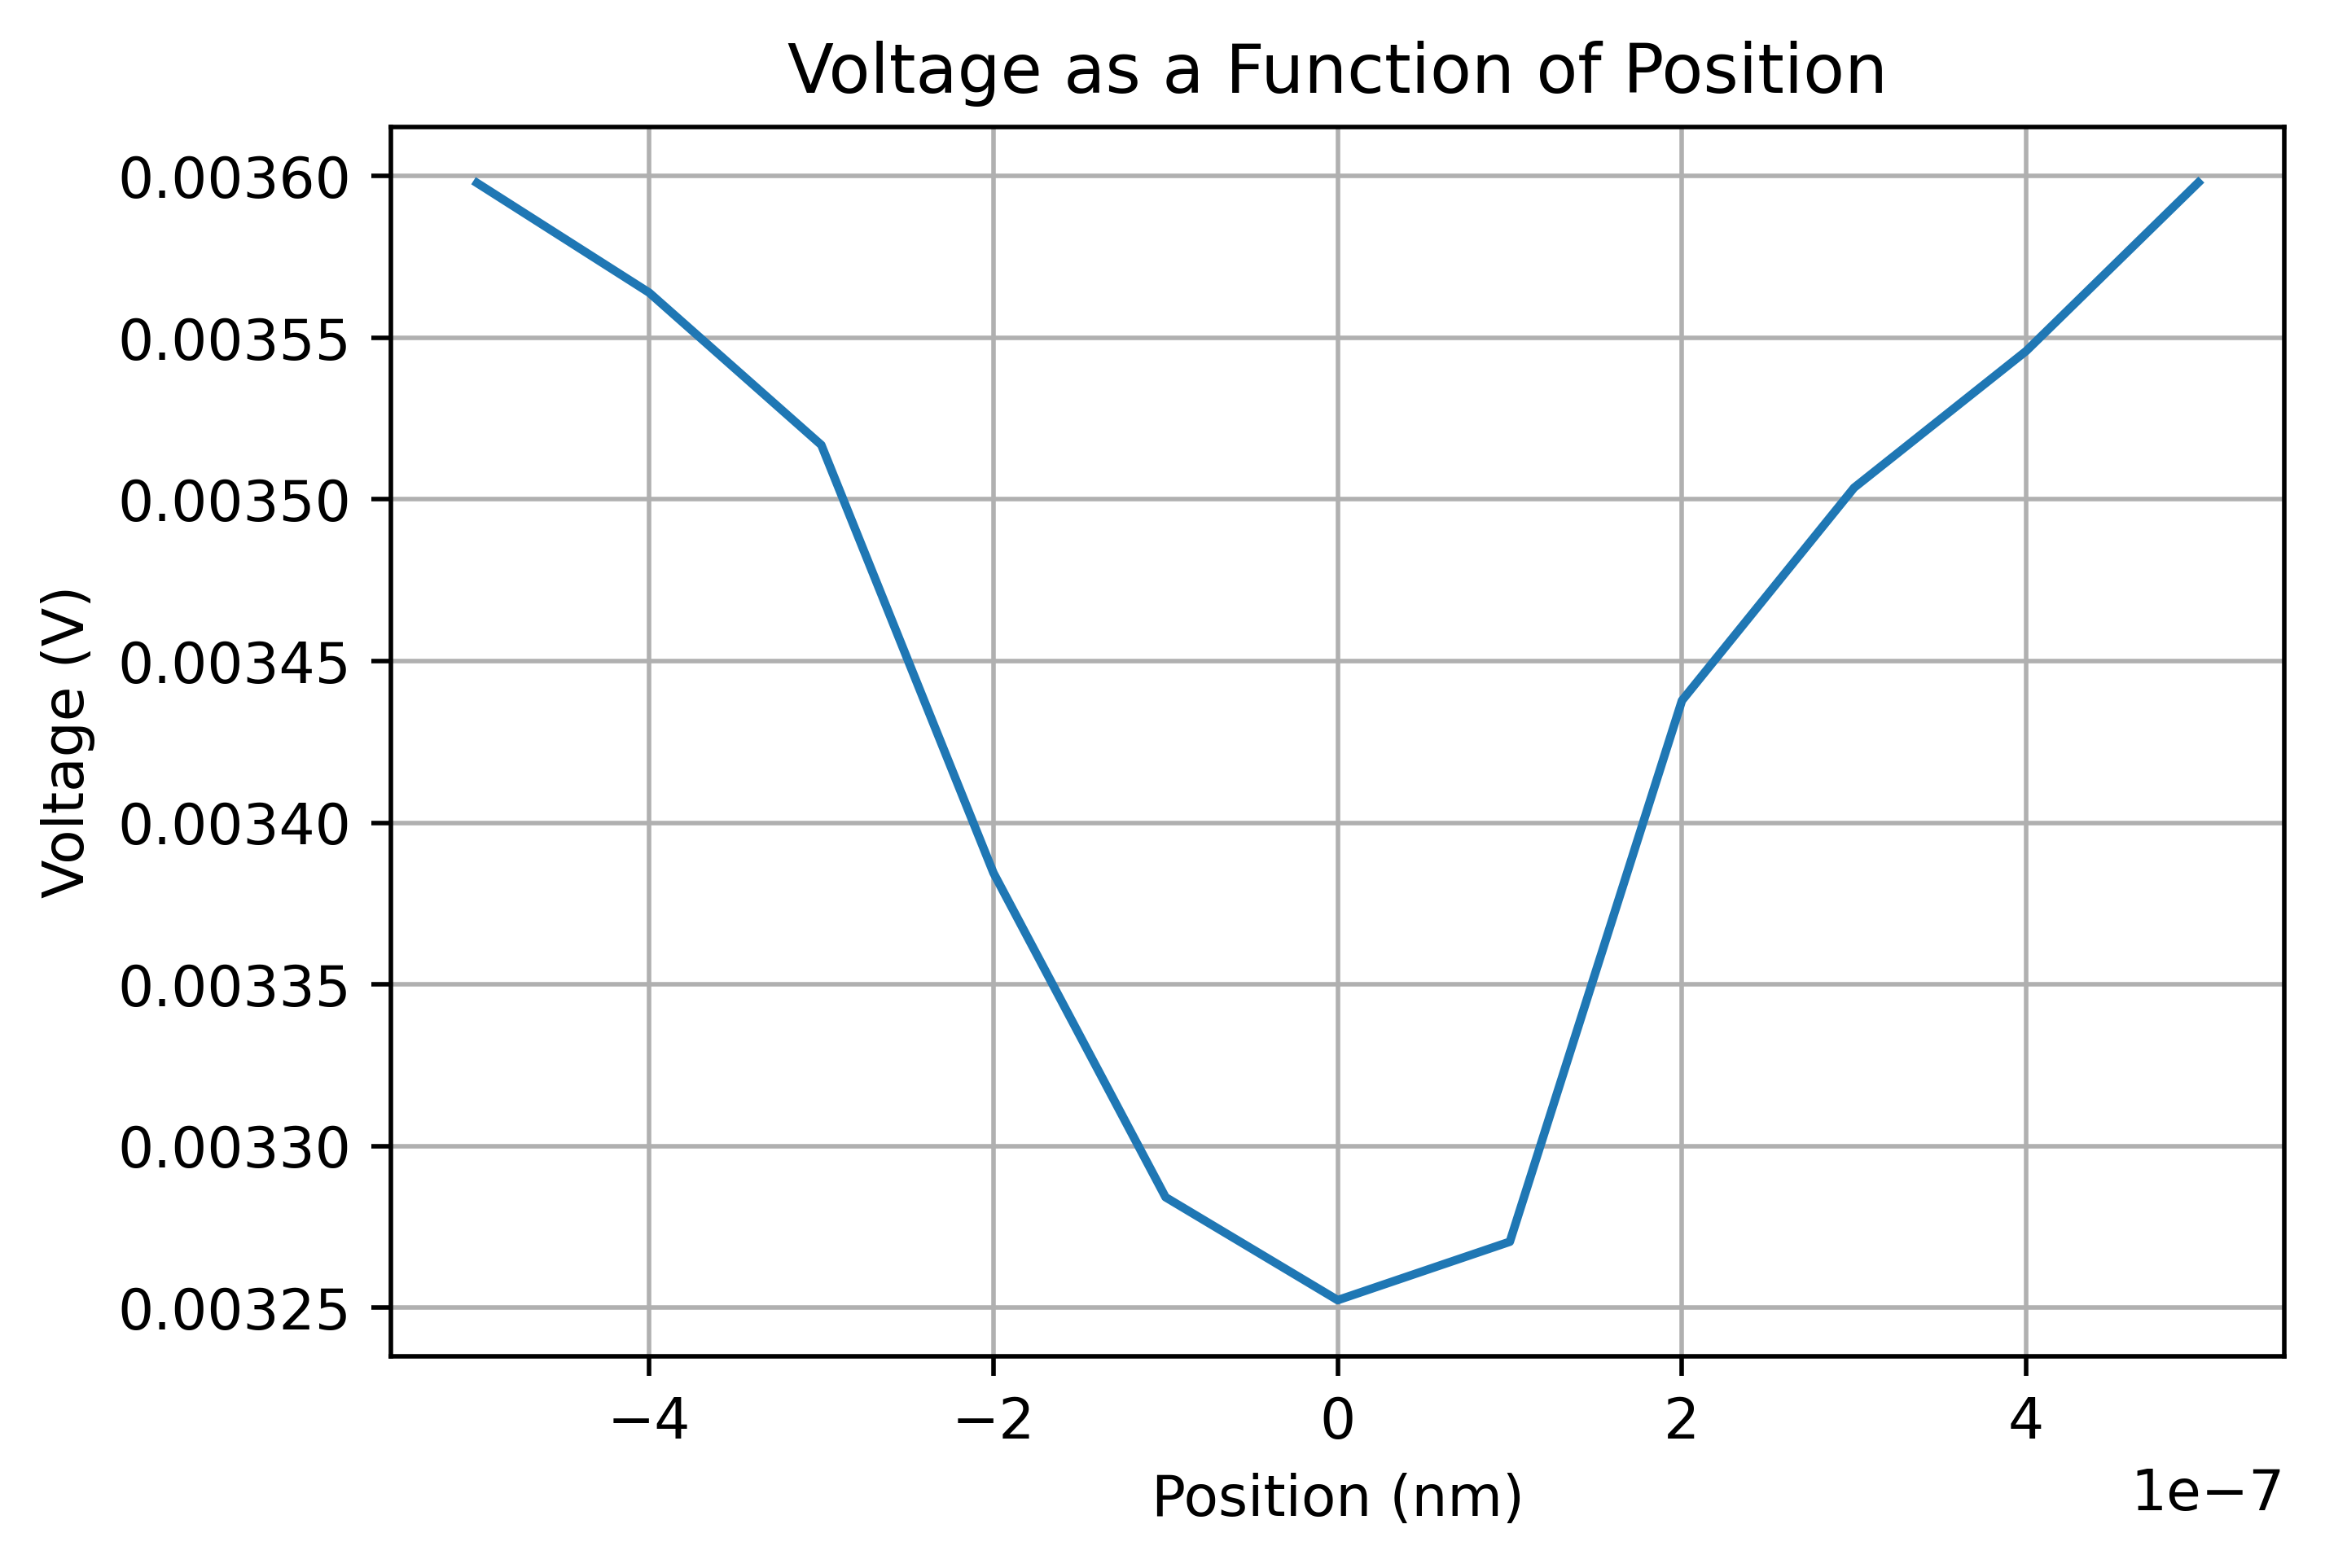

In [14]:
plt.plot(posv, volVec)
plt.grid()
plt.xlabel("Position (nm)")
plt.ylabel("Voltage (V)")
plt.title("Voltage as a Function of Position")
plt.show()